### Kinetic Parameters

This notebook contains kinetic parameters and utility functions for the final project.

Use this code with:
```python
import import_ipynb
from kinetic_parameters import rate
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp
from typing import Dict, List, Tuple
sns.set()

parameters = pd.read_csv("kinetic_parameters.csv")

def arrhenius_multiplication_factor(temperature_C : List , activation_energy_kcal : float ) -> List:
    temp_K = temperature_C + 273.15 # [ K ]
    reference_temp = 298.15 #[ K ]
    gas_constant = 1.9872E-3 # [ kcal / mol-K]
    factor = exp(activation_energy_kcal*(temp_K - reference_temp) / (gas_constant * reference_temp * temp_K)) # [ unitless ]
    return factor

def rate(controller: str, temperature_C: float = 25) -> Dict[str, float]:
    """
    Get the dictionary of model parameters for the selected controller type
    at a given temperature (in Celsius). Parameters are scaled using the
    Arrhenius equation based on their reaction type (enzyme or RNA).

    Parameters:
    - controller (str): The controller type, must be one of:
        ["direct_open_loop", "direct_closed_loop", "indirect_open_loop", "indirect_closed_loop"]
    - temperature_C (float): Temperature in degrees Celsius at which to scale the parameters.
                             Default is 25C, which references the parameters used in the paper.

    Returns:
    - Dict[str, float]: 
        - A dictionary of parameter names and their temperature-scaled values.
        
    Raises:
    - TypeError: If the controller type is not recognized.
    """
    controllers = ["direct_open_loop",
                   "direct_closed_loop",
                   "indirect_open_loop",
                   "indirect_closed_loop"]
    
    if controller not in controllers:
        print("The selected controller is not supported. Select a controller from the list:\n")
        print("\n".join(controllers))
        raise TypeError(f"Controller '{controller}' not supported.")

    parameters = pd.read_csv("kinetic_parameters.csv")

    enzyme_rxn_Ea = 15 # [ kcal / mol]
    RNA_rxn_Ea = 25 # [ kcal / mol ]

    enzyme_factor = arrhenius_multiplication_factor(temperature_C, activation_energy_kcal=enzyme_rxn_Ea)
    RNA_factor = arrhenius_multiplication_factor(temperature_C, activation_energy_kcal=RNA_rxn_Ea)

    def scale_row(row):
        factor = enzyme_factor if row["type"] == "enzyme" else RNA_factor
        value = row[controller] * factor
        return float(f"{value:.5g}") # round to 5 sig figs

    parameters["scaled_value"] = parameters.apply(scale_row, axis=1)

    rate_at_temperature = dict(zip(parameters["parameter"], parameters["scaled_value"]))
    return rate_at_temperature

#### Derivation of Kinetic Equations

Starting with the Arrhenius equation at the reference temperature $T_{ref}$ and the target temperature $T$, 
$
\begin{align}
k_{ref} &= Ae^{\frac{-E_a}{RT_{ref}}} \\
k_{T} &= Ae^{\frac{-E_a}{RT}} 
\end{align}
$

we can isolate the multiplication factor as a function of temperature by dividing the two equations and solving for $k_T$, the rate constant at the target temperature:

$
\begin{align}
\frac{k_{T}}{k_{ref}} &= e^{\frac{-E_a}{RT} - \frac{-E_a}{RT_{ref}}} \\
\frac{k_{T}}{k_{ref}} &= e^{\frac{-E_aRT_{ref} + E_aRT}{R^2TT_{ref}}} \\
k_T  &= k_{ref}e^{\frac{E_a(T - T_{ref})}{RTT_{ref}}}
\end{align}
$

#### Example:

In [101]:
myparams = rate(controller="direct_open_loop", temperature_C=30)
# print(myparams)

#### Temperature Dependence of Each Parameter Set

##### Calculate Parameter Values

In [2]:

temperatures = np.linspace(0, 90, num=100)

controllers = ["direct_open_loop",
               "direct_closed_loop",
               "indirect_open_loop",
               "indirect_closed_loop"]

def make_row(controller, T):
    param_dict = rate(controller, T)
    row = pd.Series(param_dict)
    row["controller"] = controller
    row["temperature_C"] = T
    return row

rows = []
for controller in controllers:
    for T in temperatures:
        rows.append(make_row(controller, T))

params_df = pd.DataFrame(rows)

##### Plot Parameter Temperature Dependence

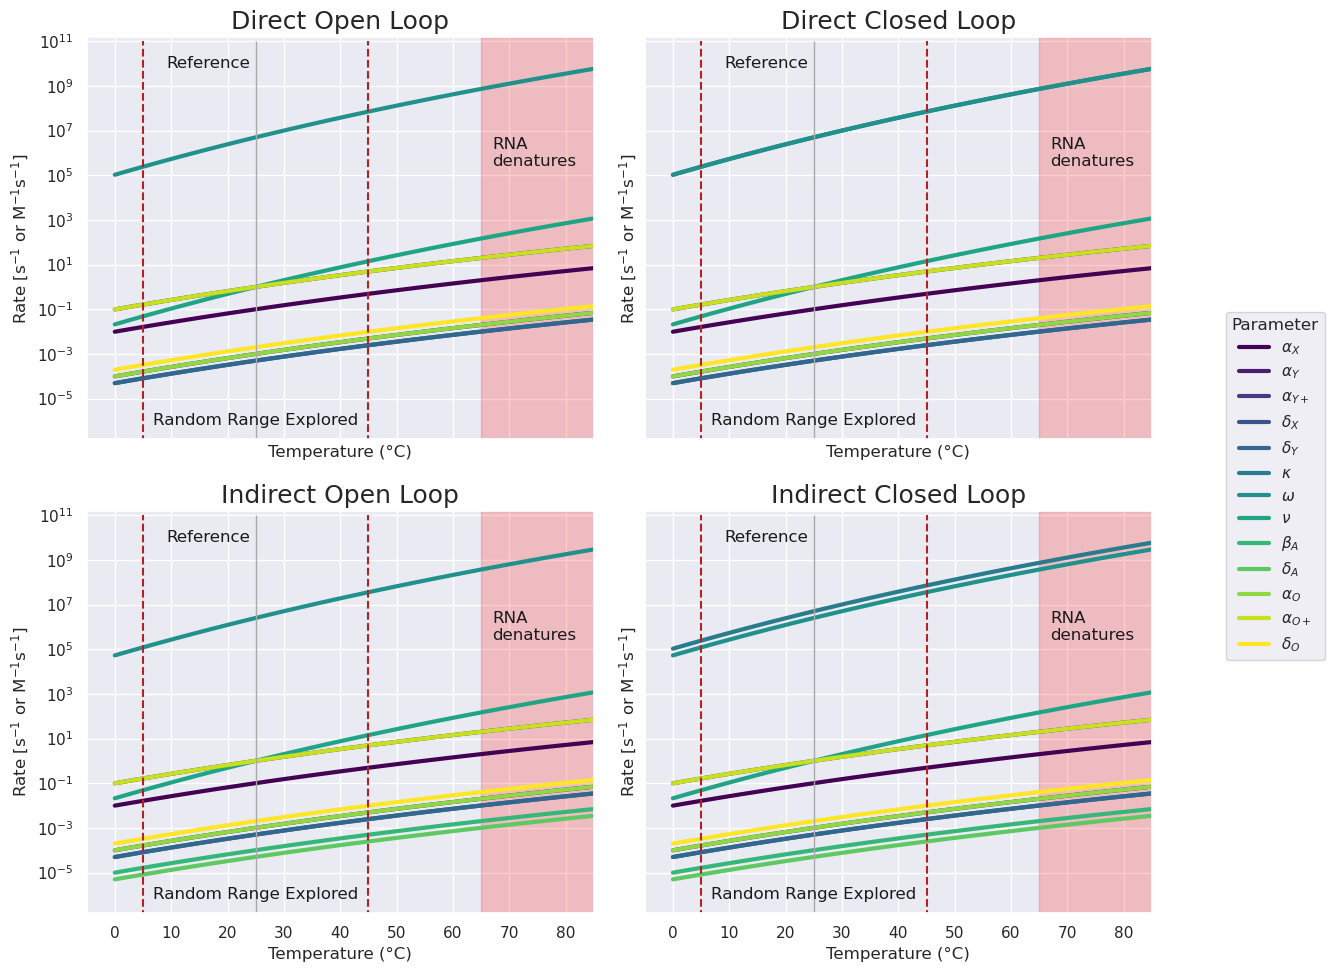

In [ ]:
plt.rcParams['font.size'] = 16  
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

param_cols = [col for col in params_df.columns if col not in ["controller", "temperature_C"]]
colors = plt.cm.viridis(np.linspace(0, 1, len(param_cols)))


def to_latex_label(param_name: str) -> str:
    """
    Convert a parameter name like 'alpha_X' or 'kappa' into a LaTeX-formatted
    label for matplotlib plotting. 
    Edited from GPT prompt: 
    'write a small function that converts strings to properly formatted 
    latex to be displayed in matplotlib like r"\alpha_X" and "\omega" etc'

    Examples:
    - 'alpha_X' -> r"$\\alpha_X$"
    - 'kappa'   -> r"$\\kappa$"
    """
    greek_letters = {'alpha', 'beta', 'delta','kappa', 'nu', 'omega' }

    parts = param_name.split('_')

    if parts[0] in greek_letters:
        base = f"\\{parts[0]}"
    else:
        base = parts[0]  # Not a greek letter, leave as is

    if len(parts) == 1:
        return rf"${base}$"
    elif len(parts) == 2:
        return rf"${base}_{{{parts[1]}}}$"
    else:
        # Join all remaining parts with _ and allow for sub/subscripts
        subscript = "_".join(parts[1:])
        return rf"${base}_{{{subscript}}}$"


# Plot each controller in a subplot
for ax, controller in zip(axes, controllers):
    subset = params_df[params_df["controller"] == controller]
    
    for color, param in zip(colors, param_cols):
        label = to_latex_label(param)
        ax.plot(subset["temperature_C"], subset[param], label=label, color=color, linewidth=3)
    ax.vlines(25, 0, 1E11, linestyle = "-", color = 'darkgray', linewidth=1)

    ax.vlines(45, 0, 1E11, linestyle = "--", color = 'firebrick')
    ax.vlines(5, 0, 1E11, linestyle = "--", color = 'firebrick')


    ax.set_title(controller.replace("_", " ").title(), fontsize=18)
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel(r"Rate [$\mathrm{s^{-1}}$ or $\mathrm{M^{-1}s^{-1}}$]")
    ax.set_yscale("log")

    ax.axvspan(65, 100, color='red', alpha=0.2)
    ax.text(67, 1E6, "RNA\ndenatures", color='k', fontsize=12, verticalalignment='center')
    ax.text(24, 1E10, "Reference", color='k', fontsize=12, verticalalignment='center', horizontalalignment="right")
    ax.text(25, 1E-6, "Random Range Explored", color='k', fontsize=12, verticalalignment='center', horizontalalignment="center")
    ax.set_xlim(-5, 85); ax.set_ylim(1.5E-7, 1.5E11)

# Use handles from one of the subplots (they're all the same)
handles, labels = axes[0].get_legend_handles_labels()

# Adjust layout to make space for the legend on the right
fig.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right
fig.legend(handles=handles, labels=labels, title="Parameter", loc='center left', bbox_to_anchor=(0.88, 0.5))

plt.show()
fig.savefig("plots/temp_dependence_of_params.png", dpi=900)